In [161]:
import geopandas as gpd
import pandas as pd
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

In [162]:
ROC_m1 = r'/Volumes/PhD/imagery/masters/ROC/M1_CT_ROC.shp'
#ROC_m1 = r'/Volumes/PhD/imagery/masters/output/ROC/design_storm/M1P_design_storm.shp'\
QROC_m1 = r'/Volumes/PhD/imagery/masters/output/ROC/QM1P_ROC.shp'
ROC_m1 = gpd.read_file(ROC_m1)

QROC_m1 = gpd.read_file(QROC_m1)
#ROC_msm1 = r'/Volumes/PhD/imagery/masters/output/ROC/MSM1_ROC.csv'
#ROC_msm1 = r'/Volumes/PhD/imagery/masters/output/ROC/design_storm/MSM1_Morepct.csv'
#ROC_msm1 = pd.read_csv(ROC_msm1, index_col=0)


mont_b =r'/Volumes/PhD/imagery/masters/hyper/ma_data.csv'
mont_b = pd.read_csv(mont_b)
QROC_m1.columns

Index(['BASIN_ID', 'Shape_Leng', 'Shape_Area', 'Segment_ID', 'Acc_Cl',
       'Perim_Buff', 'InsidePeri', 'OutsidePer', 'Fire_ID', 'Fire_Segme',
       'L_X1', 'L_X2', 'L_X3', 'V_X1', 'V_X2', 'Shape_Le_1', 'R', 'V_X3', 'X',
       'ExpX', 'P', 'PCl', 'PCl_Legend', 'LnV', 'Volume', 'VolMin', 'VolMax',
       'VolCl', 'VolCl_Lege', 'CombHaz', 'CombHazCl', 'CombHazCl_', 'area',
       'Field', 'ROC', 'nearest_st', 'distance_t', 'RI_index', 'RI',
       'Mean_dNBR', 'Med_dNBR', 'PF_dNBR', 'Basin_ID_1', 'SW_Statist',
       'SW_P_value', 'SW_Normal', 'DP_Statist', 'DP_P_value', 'DP_Normal',
       'Dip_Statis', 'Dip_P_valu', 'Bimodal', 'Q1', 'Q3', 'Q1p', 'Q3P',
       'geometry'],
      dtype='object')

In [163]:
# NEW CODE
ROC_df = {
    'BASIN_ID': ROC_m1['BASIN_ID'],
    'AREA': ROC_m1['Shape_Area'],
    'M1P_Mean': ROC_m1['M1P_Mean'],
    'M1P_Med': ROC_m1['M1P_Med'],
    'M1P_PF': ROC_m1['M1p_PF'],
    'QM1': QROC_m1['Q1p'],
    'QM3': QROC_m1['Q3P'],
    'RI': ROC_m1['RI'],
    'Old_ROC': ROC_m1['Field']
}
ROC_df = pd.DataFrame(ROC_df)
ROC_df
#non_normal_copy = ROC_df

,BASIN_ID,AREA,M1P_Mean,M1P_Med,M1P_PF,QM1,QM3,RI,Old_ROC
0,17499,1.429800e+06,0.449618,0.454098,0.438860,0.382874,0.526585,5.08,1
1,3115,4.180000e+04,0.148129,0.116710,0.101142,0.096308,0.231178,7.11,4
2,3589,4.313000e+05,0.301476,0.164258,0.122691,0.119217,0.630905,7.11,4
3,5683,5.659000e+05,0.999180,0.999251,0.999382,0.998519,0.999606,12.95,4
4,5920,7.486600e+06,0.848432,0.870989,0.910869,0.776103,0.915496,6.10,4
...,...,...,...,...,...,...,...,...,...
732,15065,9.550000e+04,0.313190,0.248063,0.189564,0.166178,0.513164,9.14,0
733,35852,8.360000e+04,0.473049,0.466838,0.444912,0.417845,0.522545,7.37,0
734,36553,4.570000e+04,0.468316,0.457159,0.448097,0.414172,0.512990,7.37,0
735,36955,1.098000e+05,0.281668,0.274903,0.249830,0.208803,0.375204,7.37,0


In [164]:
# OLD CODE DO NOT USE
""" ROC_df = {
    'BASIN_ID': ROC_m1['BASIN_ID'],
    'AREA': ROC_m1['Shape_Area'],
    'M1P_Mean': ROC_m1['M1P_Mean'],
    'M1P_Med': ROC_m1['M1P_Med'],
    'M1P_PF': ROC_m1['M1p_PF'],
    'MSM1P_Mean': ROC_msm1['MSM1_M'],
    'MSM1P_Med': ROC_msm1['MSM1_D'],
    'MSM1P_PF': ROC_msm1['MSM1_P'],
    'MSM1Pct_>50': ROC_msm1['MSM1_>50'],
    'MSM1Pct_>60': ROC_msm1['MSM1_>60'],
    'MSM1Pct_>70': ROC_msm1['MSM1_>70'],
    'MSM1Pct_>80': ROC_msm1['MSM1_>80'],
    'MSM1Pct_>90': ROC_msm1['MSM1_>90'],
    'RI': ROC_m1['RI'],
    'Old_ROC': ROC_m1['Field']
}
ROC_df = pd.DataFrame(ROC_df)
ROC_df """
#non_normal_copy = ROC_df

" ROC_df = {\n    'BASIN_ID': ROC_m1['BASIN_ID'],\n    'AREA': ROC_m1['Shape_Area'],\n    'M1P_Mean': ROC_m1['M1P_Mean'],\n    'M1P_Med': ROC_m1['M1P_Med'],\n    'M1P_PF': ROC_m1['M1p_PF'],\n    'MSM1P_Mean': ROC_msm1['MSM1_M'],\n    'MSM1P_Med': ROC_msm1['MSM1_D'],\n    'MSM1P_PF': ROC_msm1['MSM1_P'],\n    'MSM1Pct_>50': ROC_msm1['MSM1_>50'],\n    'MSM1Pct_>60': ROC_msm1['MSM1_>60'],\n    'MSM1Pct_>70': ROC_msm1['MSM1_>70'],\n    'MSM1Pct_>80': ROC_msm1['MSM1_>80'],\n    'MSM1Pct_>90': ROC_msm1['MSM1_>90'],\n    'RI': ROC_m1['RI'],\n    'Old_ROC': ROC_m1['Field']\n}\nROC_df = pd.DataFrame(ROC_df)\nROC_df "

In [165]:
#Ground truth category
ROC_df['DF'] = ROC_df['Old_ROC'].apply(lambda x: 1 if x == 1 or x == 2 else 0)

#M1 ROC setup
ROC_df['M1_Mean_50'] = ROC_df['M1P_Mean'].apply(lambda x: 1 if x > 0.5 else 0)
ROC_df['M1_Med_50'] = ROC_df['M1P_Med'].apply(lambda x: 1 if x > 0.5 else 0)
ROC_df['M1_PF_50'] = ROC_df['M1P_PF'].apply(lambda x: 1 if x > 0.5 else 0)


ROC_df['M1_Mean_60'] = ROC_df['M1P_Mean'].apply(lambda x: 1 if x > 0.6 else 0)
ROC_df['M1_Med_60'] = ROC_df['M1P_Med'].apply(lambda x: 1 if x > 0.6 else 0)
ROC_df['M1_PF_60'] = ROC_df['M1P_PF'].apply(lambda x: 1 if x > 0.6 else 0)


ROC_df['M1_Mean_70'] = ROC_df['M1P_Mean'].apply(lambda x: 1 if x > 0.7 else 0)
ROC_df['M1_Med_70'] = ROC_df['M1P_Med'].apply(lambda x: 1 if x > 0.7 else 0)
ROC_df['M1_PF_70'] = ROC_df['M1P_PF'].apply(lambda x: 1 if x > 0.7 else 0)


ROC_df['M1_Mean_80'] = ROC_df['M1P_Mean'].apply(lambda x: 1 if x > 0.8 else 0)
ROC_df['M1_Med_80'] = ROC_df['M1P_Med'].apply(lambda x: 1 if x > 0.8 else 0)
ROC_df['M1_PF_80'] = ROC_df['M1P_PF'].apply(lambda x: 1 if x > 0.8 else 0)


ROC_df['M1_Mean_90'] = ROC_df['M1P_Mean'].apply(lambda x: 1 if x > 0.9 else 0)
ROC_df['M1_Med_90'] = ROC_df['M1P_Med'].apply(lambda x: 1 if x > 0.9 else 0)
ROC_df['M1_PF_90'] = ROC_df['M1P_PF'].apply(lambda x: 1 if x > 0.9 else 0)


ROC_df['QM1_50'] = ROC_df['QM1'].apply(lambda x: 1 if x > 0.5 else 0)
ROC_df['QM1_60'] = ROC_df['QM1'].apply(lambda x: 1 if x > 0.6 else 0)
ROC_df['QM1_70'] = ROC_df['QM1'].apply(lambda x: 1 if x > 0.7 else 0)
ROC_df['QM1_80'] = ROC_df['QM1'].apply(lambda x: 1 if x > 0.8 else 0)
ROC_df['QM1_90'] = ROC_df['QM1'].apply(lambda x: 1 if x > 0.9 else 0)


ROC_df['QM3_50'] = ROC_df['QM3'].apply(lambda x: 1 if x > 0.5 else 0)
ROC_df['QM3_60'] = ROC_df['QM3'].apply(lambda x: 1 if x > 0.6 else 0)
ROC_df['QM3_70'] = ROC_df['QM3'].apply(lambda x: 1 if x > 0.7 else 0)
ROC_df['QM3_80'] = ROC_df['QM3'].apply(lambda x: 1 if x > 0.8 else 0)
ROC_df['QM3_90'] = ROC_df['QM3'].apply(lambda x: 1 if x > 0.9 else 0)
# create column observing Mean, median, and PF, if  are above .5, then classify as 1
'''ROC_df['M1_66_50'] = ROC_df.apply(
    lambda row: 1 if sum([
        row['M1P_Mean'] > 0.5,
        row['M1P_Med'] > 0.5,
        row['M1P_PF'] > 0.5
    ]) == 2 else 0,
    axis=1
)
ROC_df['M1_66_60'] = ROC_df.apply(
    lambda row: 1 if sum([
        row['M1P_Mean'] > 0.6,
        row['M1P_Med'] > 0.6,
        row['M1P_PF'] > 0.6
    ]) == 2 else 0,
    axis=1
)
ROC_df['M1_66_70'] = ROC_df.apply(
    lambda row: 1 if sum([
        row['M1P_Mean'] > 0.7,
        row['M1P_Med'] > 0.7,
        row['M1P_PF'] > 0.7
    ]) == 2 else 0,
    axis=1
)
ROC_df['M1_66_80'] = ROC_df.apply(
    lambda row: 1 if sum([
        row['M1P_Mean'] > 0.8,
        row['M1P_Med'] > 0.8,
        row['M1P_PF'] > 0.8
    ]) == 2 else 0,
    axis=1
)
ROC_df['M1_66_90'] = ROC_df.apply(
    lambda row: 1 if sum([
        row['M1P_Mean'] > 0.9,
        row['M1P_Med'] > 0.9,
        row['M1P_PF'] > 0.9
    ]) == 2 else 0,
    axis=1
)
'''
ROC_df['M1_100_50'] = ROC_df.apply(
    lambda row: 1 if sum([
        row['M1P_Mean'] > 0.5,
        row['M1P_Med'] > 0.5,
        row['M1P_PF'] > 0.5
    ]) == 3 else 0,
    axis=1
)
ROC_df['M1_100_60'] = ROC_df.apply(
    lambda row: 1 if sum([
        row['M1P_Mean'] > 0.6,
        row['M1P_Med'] > 0.6,
        row['M1P_PF'] > 0.6
    ]) == 3 else 0,
    axis=1
)
ROC_df['M1_100_70'] = ROC_df.apply(
    lambda row: 1 if sum([
        row['M1P_Mean'] > 0.7,
        row['M1P_Med'] > 0.7,
        row['M1P_PF'] > 0.7
    ]) == 3 else 0,
    axis=1
)
ROC_df['M1_100_80'] = ROC_df.apply(
    lambda row: 1 if sum([
        row['M1P_Mean'] > 0.8,
        row['M1P_Med'] > 0.8,
        row['M1P_PF'] > 0.8
    ]) == 3 else 0,
    axis=1
)
ROC_df['M1_100_90'] = ROC_df.apply(
    lambda row: 1 if sum([
        row['M1P_Mean'] > 0.9,
        row['M1P_Med'] > 0.9,
        row['M1P_PF'] > 0.9
    ]) == 3 else 0,
    axis=1
)
'''
# Create columns for QM1 and QM3
ROC_df['M1_3_50'] = ROC_df.apply(
    lambda row: 1 if sum([
        row['M1P_Mean'] > 0.5,
        row['M1P_Med'] > 0.5,
        row['M1P_PF'] > 0.5,
        row['QM1_50'] > 0.5,
        row['QM3_50'] > 0.5
    ]) == 3 else 0,
    axis=1
)
ROC_df['M1_3_60'] = ROC_df.apply(
    lambda row: 1 if sum([
        row['M1P_Mean'] > 0.6,
        row['M1P_Med'] > 0.6,
        row['M1P_PF'] > 0.6,
        row['QM1_60'] > 0.6,
        row['QM3_60'] > 0.6
    ]) == 3 else 0,
    axis=1
)
ROC_df['M1_3_70'] = ROC_df.apply(
    lambda row: 1 if sum([
        row['M1P_Mean'] > 0.7,
        row['M1P_Med'] > 0.7,
        row['M1P_PF'] > 0.7,
        row['QM1_70'] > 0.7,
        row['QM3_70'] > 0.7
    ]) == 3 else 0,
    axis=1
)
ROC_df['M1_3_80'] = ROC_df.apply(
    lambda row: 1 if sum([
        row['M1P_Mean'] > 0.8,
        row['M1P_Med'] > 0.8,
        row['M1P_PF'] > 0.8,
        row['QM1_80'] > 0.8,
        row['QM3_80'] > 0.8
    ]) == 3 else 0,
    axis=1
)
ROC_df['M1_3_90'] = ROC_df.apply(
    lambda row: 1 if sum([
        row['M1P_Mean'] > 0.9,
        row['M1P_Med'] > 0.9,
        row['M1P_PF'] > 0.9,
        row['QM1_90'] > 0.9,
        row['QM3_90'] > 0.9
    ]) == 3 else 0,
    axis=1
)

# Four of 5
ROC_df['M1_4_50'] = ROC_df.apply(
    lambda row: 1 if sum([
        row['M1P_Mean'] > 0.5,
        row['M1P_Med'] > 0.5,
        row['M1P_PF'] > 0.5,
        row['QM1_50'] > 0.5,
        row['QM3_50'] > 0.5
    ]) == 4 else 0,
    axis=1
)
ROC_df['M1_4_60'] = ROC_df.apply(
    lambda row: 1 if sum([
        row['M1P_Mean'] > 0.6,
        row['M1P_Med'] > 0.6,
        row['M1P_PF'] > 0.6,
        row['QM1_60'] > 0.6,
        row['QM3_60'] > 0.6
    ]) == 4 else 0,
    axis=1
)
ROC_df['M1_4_70'] = ROC_df.apply(
    lambda row: 1 if sum([
        row['M1P_Mean'] > 0.7,
        row['M1P_Med'] > 0.7,
        row['M1P_PF'] > 0.7,
        row['QM1_70'] > 0.7,
        row['QM3_70'] > 0.7
    ]) == 4 else 0,
    axis=1
)
ROC_df['M1_4_80'] = ROC_df.apply(
    lambda row: 1 if sum([
        row['M1P_Mean'] > 0.8,
        row['M1P_Med'] > 0.8,
        row['M1P_PF'] > 0.8,
        row['QM1_80'] > 0.8,
        row['QM3_80'] > 0.8
    ]) == 4 else 0,
    axis=1
)
ROC_df['M1_4_90'] = ROC_df.apply(
    lambda row: 1 if sum([
        row['M1P_Mean'] > 0.9,
        row['M1P_Med'] > 0.9,
        row['M1P_PF'] > 0.9,
        row['QM1_90'] > 0.9,
        row['QM3_90'] > 0.9
    ]) == 4 else 0,
    axis=1
)
'''
# All 5
ROC_df['M1_5_50'] = ROC_df.apply(
    lambda row: 1 if sum([
        row['M1P_Mean'] > 0.5,
        row['M1P_Med'] > 0.5,
        row['M1P_PF'] > 0.5,
        row['QM1_50'] > 0.5,
        row['QM3_50'] > 0.5
    ]) == 5 else 0,
    axis=1
)
ROC_df['M1_5_60'] = ROC_df.apply(
    lambda row: 1 if sum([
        row['M1P_Mean'] > 0.6,
        row['M1P_Med'] > 0.6,
        row['M1P_PF'] > 0.6,
        row['QM1_60'] > 0.6,
        row['QM3_60'] > 0.6
    ]) == 5 else 0,
    axis=1
)
ROC_df['M1_5_70'] = ROC_df.apply(
    lambda row: 1 if sum([
        row['M1P_Mean'] > 0.7,
        row['M1P_Med'] > 0.7,
        row['M1P_PF'] > 0.7,
        row['QM1_70'] > 0.7,
        row['QM3_70'] > 0.7
    ]) == 5 else 0,
    axis=1
)
ROC_df['M1_5_80'] = ROC_df.apply(
    lambda row: 1 if sum([
        row['M1P_Mean'] > 0.8,
        row['M1P_Med'] > 0.8,
        row['M1P_PF'] > 0.8,
        row['QM1_80'] > 0.8,
        row['QM3_80'] > 0.8
    ]) == 5 else 0,
    axis=1
)
ROC_df['M1_5_90'] = ROC_df.apply(
    lambda row: 1 if sum([
        row['M1P_Mean'] > 0.9,
        row['M1P_Med'] > 0.9,
        row['M1P_PF'] > 0.9,
        row['QM1_90'] > 0.9,
        row['QM3_90'] > 0.9
    ]) == 5 else 0,
    axis=1
)

ROC_df

,BASIN_ID,AREA,M1P_Mean,M1P_Med,M1P_PF,QM1,QM3,RI,Old_ROC,DF,...,M1_100_50,M1_100_60,M1_100_70,M1_100_80,M1_100_90,M1_5_50,M1_5_60,M1_5_70,M1_5_80,M1_5_90
0,17499,1.429800e+06,0.449618,0.454098,0.438860,0.382874,0.526585,5.08,1,1,...,0,0,0,0,0,0,0,0,0,0
1,3115,4.180000e+04,0.148129,0.116710,0.101142,0.096308,0.231178,7.11,4,0,...,0,0,0,0,0,0,0,0,0,0
2,3589,4.313000e+05,0.301476,0.164258,0.122691,0.119217,0.630905,7.11,4,0,...,0,0,0,0,0,0,0,0,0,0
3,5683,5.659000e+05,0.999180,0.999251,0.999382,0.998519,0.999606,12.95,4,0,...,1,1,1,1,1,1,1,1,1,1
4,5920,7.486600e+06,0.848432,0.870989,0.910869,0.776103,0.915496,6.10,4,0,...,1,1,1,1,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,15065,9.550000e+04,0.313190,0.248063,0.189564,0.166178,0.513164,9.14,0,0,...,0,0,0,0,0,0,0,0,0,0
733,35852,8.360000e+04,0.473049,0.466838,0.444912,0.417845,0.522545,7.37,0,0,...,0,0,0,0,0,0,0,0,0,0
734,36553,4.570000e+04,0.468316,0.457159,0.448097,0.414172,0.512990,7.37,0,0,...,0,0,0,0,0,0,0,0,0,0
735,36955,1.098000e+05,0.281668,0.274903,0.249830,0.208803,0.375204,7.37,0,0,...,0,0,0,0,0,0,0,0,0,0


In [166]:
#ROC_df.to_csv(r'/Volumes/PhD/imagery/masters/ROC/M1-MSM1_ROC.csv')
large_basins_df = ROC_df[ROC_df['AREA'] >= 1000000]
small_basins_df = ROC_df[ROC_df['AREA'] <= 1000000]


high_R = ROC_df[ROC_df['RI']>= 10]
high_R
low_R = ROC_df[ROC_df['RI'] < 10]
low_R


,BASIN_ID,AREA,M1P_Mean,M1P_Med,M1P_PF,QM1,QM3,RI,Old_ROC,DF,...,M1_100_50,M1_100_60,M1_100_70,M1_100_80,M1_100_90,M1_5_50,M1_5_60,M1_5_70,M1_5_80,M1_5_90
0,17499,1.429800e+06,0.449618,0.454098,0.438860,0.382874,0.526585,5.08,1,1,...,0,0,0,0,0,0,0,0,0,0
1,3115,4.180000e+04,0.148129,0.116710,0.101142,0.096308,0.231178,7.11,4,0,...,0,0,0,0,0,0,0,0,0,0
2,3589,4.313000e+05,0.301476,0.164258,0.122691,0.119217,0.630905,7.11,4,0,...,0,0,0,0,0,0,0,0,0,0
4,5920,7.486600e+06,0.848432,0.870989,0.910869,0.776103,0.915496,6.10,4,0,...,1,1,1,1,0,1,1,1,0,0
5,7185,4.314900e+06,0.866735,0.877320,0.904633,0.811017,0.914586,6.10,4,0,...,1,1,1,1,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,15065,9.550000e+04,0.313190,0.248063,0.189564,0.166178,0.513164,9.14,0,0,...,0,0,0,0,0,0,0,0,0,0
733,35852,8.360000e+04,0.473049,0.466838,0.444912,0.417845,0.522545,7.37,0,0,...,0,0,0,0,0,0,0,0,0,0
734,36553,4.570000e+04,0.468316,0.457159,0.448097,0.414172,0.512990,7.37,0,0,...,0,0,0,0,0,0,0,0,0,0
735,36955,1.098000e+05,0.281668,0.274903,0.249830,0.208803,0.375204,7.37,0,0,...,0,0,0,0,0,0,0,0,0,0


In [187]:
b12042 = ROC_df[ROC_df['BASIN_ID'] == 12042]
b12042

,BASIN_ID,AREA,M1P_Mean,M1P_Med,M1P_PF,QM1,QM3,RI,Old_ROC,DF,...,M1_100_50,M1_100_60,M1_100_70,M1_100_80,M1_100_90,M1_5_50,M1_5_60,M1_5_70,M1_5_80,M1_5_90
173,12042,480599.999999,0.929195,0.781093,0.594378,0.550642,0.983338,19.56,3,0,...,1,0,0,0,0,1,0,0,0,0


In [167]:
def compute_roc(df, ground_truth, prediction_col):
    results = []

    for pred_col in prediction_col:
        TP = ((df[ground_truth] == 1) & (df[pred_col] == 1)).sum()
        FP = ((df[ground_truth] == 0) & (df[pred_col] == 1)).sum()
        TN = ((df[ground_truth] == 0) & (df[pred_col] == 0)).sum()
        FN = ((df[ground_truth] == 1) & (df[pred_col] == 0)).sum()

        TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) != 0 else 0
        SPC = TN / (TN + FP)
        ACC = (TP + TN) / (TP + TN + FP + FN)
        THT = TP / (TP + FP + FN)

        # Calculate AUC using scikit-learn's roc_curve and auc functions
        fpr, tpr, _ = roc_curve(df[ground_truth], df[pred_col])
        roc_auc = auc(fpr, tpr)

        # Append results
        results.append({
            "Prediction Column": pred_col,
            "TP": TP,
            "FP": FP,
            "TN": TN,
            "FN": FN,
            "Sensitivity": TPR,
            "FPR": FPR,
            'Specificity': SPC,
            'Accuracy': ACC,
            "AUC": roc_auc,
            'Threat Score': THT
        })
    return pd.DataFrame(results)

In [168]:
columns_after_df = ROC_df.columns[ROC_df.columns.get_loc('DF') + 1:]
columns_after_df


Index(['M1_Mean_50', 'M1_Med_50', 'M1_PF_50', 'M1_Mean_60', 'M1_Med_60',
       'M1_PF_60', 'M1_Mean_70', 'M1_Med_70', 'M1_PF_70', 'M1_Mean_80',
       'M1_Med_80', 'M1_PF_80', 'M1_Mean_90', 'M1_Med_90', 'M1_PF_90',
       'QM1_50', 'QM1_60', 'QM1_70', 'QM1_80', 'QM1_90', 'QM3_50', 'QM3_60',
       'QM3_70', 'QM3_80', 'QM3_90', 'M1_100_50', 'M1_100_60', 'M1_100_70',
       'M1_100_80', 'M1_100_90', 'M1_5_50', 'M1_5_60', 'M1_5_70', 'M1_5_80',
       'M1_5_90'],
      dtype='object')

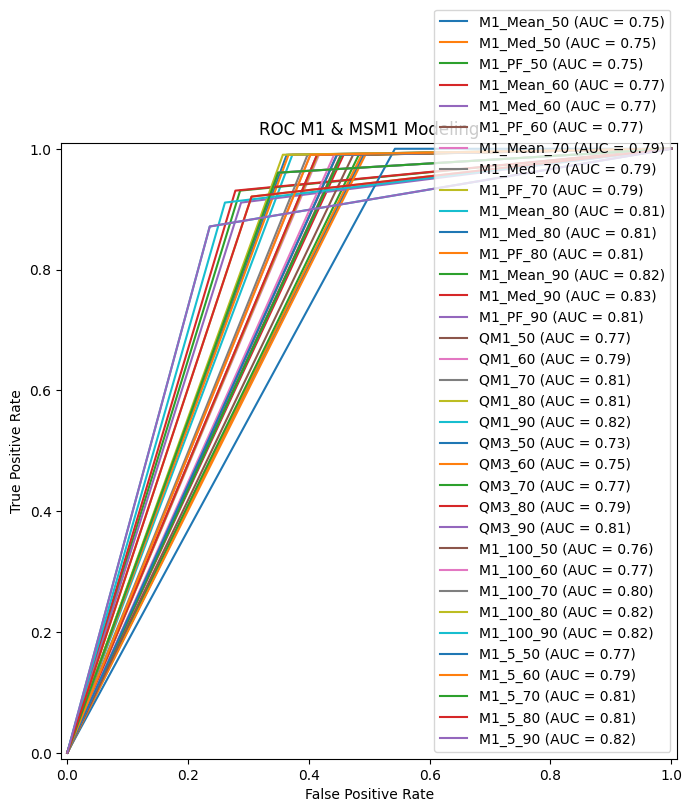

In [169]:
ground_truth_col = 'DF'
roc_results = compute_roc(ROC_df, ground_truth_col, columns_after_df)



# Optional: Plot ROC curves for each column
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
for pred_col in columns_after_df:
    fpr, tpr, _ = roc_curve(ROC_df['DF'], ROC_df[pred_col])
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr), estimator_name=pred_col).plot(ax=plt.gca())

plt.title('ROC M1 & MSM1 Modeling')
plt.legend(loc='lower right')
plt.show()

In [171]:
roc_results


,Prediction Column,TP,FP,TN,FN,Sensitivity,FPR,Specificity,Accuracy,AUC,Threat Score
0,M1_Mean_50,100,312,324,1,0.990099,0.490566,0.509434,0.575305,0.749766,0.242131
1,M1_Med_50,100,310,326,1,0.990099,0.487421,0.512579,0.578019,0.751339,0.243309
2,M1_PF_50,100,307,329,1,0.990099,0.482704,0.517296,0.582090,0.753697,0.245098
3,M1_Mean_60,100,291,345,1,0.990099,0.457547,0.542453,0.603799,0.766276,0.255102
4,M1_Med_60,100,289,347,1,0.990099,0.454403,0.545597,0.606513,0.767848,0.256410
5,M1_PF_60,100,288,348,1,0.990099,0.452830,0.547170,0.607870,0.768634,0.257069
6,M1_Mean_70,100,265,371,1,0.990099,0.416667,0.583333,0.639077,0.786716,0.273224
7,M1_Med_70,100,263,373,1,0.990099,0.413522,0.586478,0.641791,0.788288,0.274725
8,M1_PF_70,100,264,372,1,0.990099,0.415094,0.584906,0.640434,0.787502,0.273973
9,M1_Mean_80,100,237,399,1,0.990099,0.372642,0.627358,0.677069,0.808729,0.295858


In [172]:
roc_results.to_csv(r'/Volumes/PhD/imagery/masters/ROC/M1-MSM1_ROC_results_morepct.csv')


In [173]:
low_R_results = compute_roc(low_R, ground_truth_col, columns_after_df)
low_R_results

,Prediction Column,TP,FP,TN,FN,Sensitivity,FPR,Specificity,Accuracy,AUC,Threat Score
0,M1_Mean_50,27,199,323,1,0.964286,0.381226,0.618774,0.636364,0.791530,0.118943
1,M1_Med_50,27,197,325,1,0.964286,0.377395,0.622605,0.640000,0.793446,0.120000
2,M1_PF_50,27,196,326,1,0.964286,0.375479,0.624521,0.641818,0.794403,0.120536
3,M1_Mean_60,27,178,344,1,0.964286,0.340996,0.659004,0.674545,0.811645,0.131068
4,M1_Med_60,27,176,346,1,0.964286,0.337165,0.662835,0.678182,0.813560,0.132353
5,M1_PF_60,27,178,344,1,0.964286,0.340996,0.659004,0.674545,0.811645,0.131068
6,M1_Mean_70,27,153,369,1,0.964286,0.293103,0.706897,0.720000,0.835591,0.149171
7,M1_Med_70,27,153,369,1,0.964286,0.293103,0.706897,0.720000,0.835591,0.149171
8,M1_PF_70,27,157,365,1,0.964286,0.300766,0.699234,0.712727,0.831760,0.145946
9,M1_Mean_80,27,126,396,1,0.964286,0.241379,0.758621,0.769091,0.861453,0.175325


In [174]:
high_R_results = compute_roc(high_R, ground_truth_col, columns_after_df)
high_R_results

,Prediction Column,TP,FP,TN,FN,Sensitivity,FPR,Specificity,Accuracy,AUC,Threat Score
0,M1_Mean_50,73,113,1,0,1.000000,0.991228,0.008772,0.395722,0.504386,0.392473
1,M1_Med_50,73,113,1,0,1.000000,0.991228,0.008772,0.395722,0.504386,0.392473
2,M1_PF_50,73,111,3,0,1.000000,0.973684,0.026316,0.406417,0.513158,0.396739
3,M1_Mean_60,73,113,1,0,1.000000,0.991228,0.008772,0.395722,0.504386,0.392473
4,M1_Med_60,73,113,1,0,1.000000,0.991228,0.008772,0.395722,0.504386,0.392473
5,M1_PF_60,73,110,4,0,1.000000,0.964912,0.035088,0.411765,0.517544,0.398907
6,M1_Mean_70,73,112,2,0,1.000000,0.982456,0.017544,0.401070,0.508772,0.394595
7,M1_Med_70,73,110,4,0,1.000000,0.964912,0.035088,0.411765,0.517544,0.398907
8,M1_PF_70,73,107,7,0,1.000000,0.938596,0.061404,0.427807,0.530702,0.405556
9,M1_Mean_80,73,111,3,0,1.000000,0.973684,0.026316,0.406417,0.513158,0.396739


In [175]:
small_results = compute_roc(small_basins_df, ground_truth_col, columns_after_df)
small_results

,Prediction Column,TP,FP,TN,FN,Sensitivity,FPR,Specificity,Accuracy,AUC,Threat Score
0,M1_Mean_50,64,280,288,0,1.000000,0.492958,0.507042,0.556962,0.753521,0.186047
1,M1_Med_50,64,277,291,0,1.000000,0.487676,0.512324,0.561709,0.756162,0.187683
2,M1_PF_50,64,272,296,0,1.000000,0.478873,0.521127,0.569620,0.760563,0.190476
3,M1_Mean_60,64,261,307,0,1.000000,0.459507,0.540493,0.587025,0.770246,0.196923
4,M1_Med_60,64,259,309,0,1.000000,0.455986,0.544014,0.590190,0.772007,0.198142
5,M1_PF_60,64,256,312,0,1.000000,0.450704,0.549296,0.594937,0.774648,0.200000
6,M1_Mean_70,64,238,330,0,1.000000,0.419014,0.580986,0.623418,0.790493,0.211921
7,M1_Med_70,64,235,333,0,1.000000,0.413732,0.586268,0.628165,0.793134,0.214047
8,M1_PF_70,64,235,333,0,1.000000,0.413732,0.586268,0.628165,0.793134,0.214047
9,M1_Mean_80,64,215,353,0,1.000000,0.378521,0.621479,0.659810,0.810739,0.229391


In [176]:
large_results = compute_roc(large_basins_df, ground_truth_col, columns_after_df)
large_results

,Prediction Column,TP,FP,TN,FN,Sensitivity,FPR,Specificity,Accuracy,AUC,Threat Score
0,M1_Mean_50,36,32,36,1,0.972973,0.470588,0.529412,0.685714,0.751192,0.521739
1,M1_Med_50,36,33,35,1,0.972973,0.485294,0.514706,0.676190,0.743839,0.514286
2,M1_PF_50,36,35,33,1,0.972973,0.514706,0.485294,0.657143,0.729134,0.500000
3,M1_Mean_60,36,30,38,1,0.972973,0.441176,0.558824,0.704762,0.765898,0.537313
4,M1_Med_60,36,30,38,1,0.972973,0.441176,0.558824,0.704762,0.765898,0.537313
5,M1_PF_60,36,32,36,1,0.972973,0.470588,0.529412,0.685714,0.751192,0.521739
6,M1_Mean_70,36,27,41,1,0.972973,0.397059,0.602941,0.733333,0.787957,0.562500
7,M1_Med_70,36,28,40,1,0.972973,0.411765,0.588235,0.723810,0.780604,0.553846
8,M1_PF_70,36,29,39,1,0.972973,0.426471,0.573529,0.714286,0.773251,0.545455
9,M1_Mean_80,36,22,46,1,0.972973,0.323529,0.676471,0.780952,0.824722,0.610169


In [16]:
small_results.to_csv(r'/Volumes/PhD/imagery/masters/ROC/M1-MSM1_ROC_small-results.csv')
large_results.to_csv(r'/Volumes/PhD/imagery/masters/ROC/M1-MSM1_ROC_large-results.csv')

In [177]:
non_normal_stats = pd.read_csv(r'/Volumes/PhD/imagery/masters/output/normality/normality_test_results_filtered.csv')
non_normal_stats

,Basin_ID,SW_Statistic,SW_P_value,SW_Normal,DP_Statistic,DP_P_value,DP_Normal,Dip_Statistic,Dip_P_value,Bimodal
0,10048,0.985049,1.287702e-05,1,12.362344,2.068002e-03,1,0.013168,0.773796,0
1,10058,0.891842,7.096566e-06,1,10.681829,4.791486e-03,1,0.025264,0.990390,0
2,10060,0.912353,5.436477e-04,1,3.475222,1.759402e-01,0,0.041927,0.667167,0
3,10104,0.853367,1.239101e-08,1,27.076409,1.319570e-06,1,0.028374,0.848372,0
4,10155,0.956637,8.430536e-20,1,144.968298,3.315386e-32,1,0.007702,0.906938,0
...,...,...,...,...,...,...,...,...,...,...
732,9865,0.945665,7.641928e-03,1,3.039715,2.187431e-01,0,0.060413,0.077533,2
733,9906,0.984439,4.395452e-02,1,4.320410,1.153015e-01,0,0.029931,0.315710,0
734,9959,0.920445,7.391726e-07,1,32.367704,9.363588e-08,1,0.044982,0.044959,1
735,9974,0.958141,9.943072e-25,1,147.474170,9.470892e-33,1,0.004796,0.992495,0


In [178]:
SW_NN = non_normal_stats[(non_normal_stats['SW_Normal'] == 1) & (non_normal_stats['Bimodal'] == 0)]
SW_NN
#subset_ids = non_normal_stats['BASIN_ID']

NN_df = ROC_df[ROC_df['BASIN_ID'].isin(SW_NN['Basin_ID'])]
NN_df

strbdf = non_normal_stats[non_normal_stats['Bimodal'] == 1]
wkbdf = non_normal_stats[non_normal_stats['Bimodal'] == 2]
#combine two dataframes
bdf = pd.concat([strbdf, wkbdf], ignore_index=True)
bdf
B_df = ROC_df[ROC_df['BASIN_ID'].isin(bdf['Basin_ID'])]
B_df
#NN_df = subset_df.merge(non_normal[['BASIN_ID', 'Skewed/Bimodal']], on='BASIN_ID', how='left')
#NN_df = NN_df.merge(ROC_df, on='BASIN_ID', how='left')
#NN_df


,BASIN_ID,AREA,M1P_Mean,M1P_Med,M1P_PF,QM1,QM3,RI,Old_ROC,DF,...,M1_100_50,M1_100_60,M1_100_70,M1_100_80,M1_100_90,M1_5_50,M1_5_60,M1_5_70,M1_5_80,M1_5_90
2,3589,4.313000e+05,0.301476,0.164258,0.122691,0.119217,0.630905,7.11,4,0,...,0,0,0,0,0,0,0,0,0,0
13,11514,4.281000e+05,0.999994,0.999994,1.000000,0.999900,1.000000,25.15,4,0,...,1,1,1,1,1,1,1,1,1,1
17,12057,3.219000e+05,0.998743,0.999379,0.999738,0.988967,0.999865,19.56,4,0,...,1,1,1,1,1,1,1,1,1,1
19,12288,1.067700e+06,0.989992,0.988160,0.981650,0.975150,0.996711,9.14,4,0,...,1,1,1,1,1,1,1,1,1,1
21,12729,5.681000e+05,0.993064,0.994618,0.996769,0.984383,0.996994,9.14,4,0,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,2760,4.034000e+05,0.344944,0.359747,0.146731,0.165663,0.555222,7.11,0,0,...,0,0,0,0,0,0,0,0,0,0
720,3849,3.009000e+05,0.178021,0.112873,0.106470,0.096610,0.161690,7.11,0,0,...,0,0,0,0,0,0,0,0,0,0
722,6537,1.950000e+05,0.372509,0.333094,0.173935,0.174419,0.586489,6.10,0,0,...,0,0,0,0,0,0,0,0,0,0
729,19058,2.172000e+05,0.123042,0.096739,0.076722,0.075012,0.211558,5.08,0,0,...,0,0,0,0,0,0,0,0,0,0


In [179]:
NNroc_results = compute_roc(NN_df, ground_truth_col, columns_after_df)
NNroc_results


,Prediction Column,TP,FP,TN,FN,Sensitivity,FPR,Specificity,Accuracy,AUC,Threat Score
0,M1_Mean_50,78,226,216,1,0.987342,0.511312,0.488688,0.564299,0.738015,0.255738
1,M1_Med_50,78,224,218,1,0.987342,0.506787,0.493213,0.568138,0.740277,0.257426
2,M1_PF_50,78,223,219,1,0.987342,0.504525,0.495475,0.570058,0.741408,0.258278
3,M1_Mean_60,78,209,233,1,0.987342,0.472851,0.527149,0.596929,0.757246,0.270833
4,M1_Med_60,78,210,232,1,0.987342,0.475113,0.524887,0.595010,0.756114,0.269896
5,M1_PF_60,78,208,234,1,0.987342,0.470588,0.529412,0.598848,0.758377,0.271777
6,M1_Mean_70,78,192,250,1,0.987342,0.434389,0.565611,0.629559,0.776476,0.287823
7,M1_Med_70,78,189,253,1,0.987342,0.427602,0.572398,0.635317,0.779870,0.291045
8,M1_PF_70,78,189,253,1,0.987342,0.427602,0.572398,0.635317,0.779870,0.291045
9,M1_Mean_80,78,170,272,1,0.987342,0.384615,0.615385,0.671785,0.801363,0.313253


In [180]:
bimodal_results = compute_roc(B_df, ground_truth_col, columns_after_df)
bimodal_results

,Prediction Column,TP,FP,TN,FN,Sensitivity,FPR,Specificity,Accuracy,AUC,Threat Score
0,M1_Mean_50,16,39,31,0,1.0000,0.557143,0.442857,0.546512,0.721429,0.290909
1,M1_Med_50,16,40,30,0,1.0000,0.571429,0.428571,0.534884,0.714286,0.285714
2,M1_PF_50,16,39,31,0,1.0000,0.557143,0.442857,0.546512,0.721429,0.290909
3,M1_Mean_60,16,38,32,0,1.0000,0.542857,0.457143,0.558140,0.728571,0.296296
4,M1_Med_60,16,36,34,0,1.0000,0.514286,0.485714,0.581395,0.742857,0.307692
5,M1_PF_60,16,37,33,0,1.0000,0.528571,0.471429,0.569767,0.735714,0.301887
6,M1_Mean_70,16,34,36,0,1.0000,0.485714,0.514286,0.604651,0.757143,0.320000
7,M1_Med_70,16,35,35,0,1.0000,0.500000,0.500000,0.593023,0.750000,0.313725
8,M1_PF_70,16,35,35,0,1.0000,0.500000,0.500000,0.593023,0.750000,0.313725
9,M1_Mean_80,16,32,38,0,1.0000,0.457143,0.542857,0.627907,0.771429,0.333333


In [181]:
# Montecito Basin removal, if needed

MROC_df = ROC_df[~ROC_df['BASIN_ID'].isin(mont_b['basin_id'])]
#MROC_df = ROC_df[~ROC_df['BASIN_ID'].isin(mont_b1['basin_id'])]
MROC_df


,BASIN_ID,AREA,M1P_Mean,M1P_Med,M1P_PF,QM1,QM3,RI,Old_ROC,DF,...,M1_100_50,M1_100_60,M1_100_70,M1_100_80,M1_100_90,M1_5_50,M1_5_60,M1_5_70,M1_5_80,M1_5_90
0,17499,1.429800e+06,0.449618,0.454098,0.438860,0.382874,0.526585,5.08,1,1,...,0,0,0,0,0,0,0,0,0,0
1,3115,4.180000e+04,0.148129,0.116710,0.101142,0.096308,0.231178,7.11,4,0,...,0,0,0,0,0,0,0,0,0,0
2,3589,4.313000e+05,0.301476,0.164258,0.122691,0.119217,0.630905,7.11,4,0,...,0,0,0,0,0,0,0,0,0,0
3,5683,5.659000e+05,0.999180,0.999251,0.999382,0.998519,0.999606,12.95,4,0,...,1,1,1,1,1,1,1,1,1,1
4,5920,7.486600e+06,0.848432,0.870989,0.910869,0.776103,0.915496,6.10,4,0,...,1,1,1,1,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,15065,9.550000e+04,0.313190,0.248063,0.189564,0.166178,0.513164,9.14,0,0,...,0,0,0,0,0,0,0,0,0,0
733,35852,8.360000e+04,0.473049,0.466838,0.444912,0.417845,0.522545,7.37,0,0,...,0,0,0,0,0,0,0,0,0,0
734,36553,4.570000e+04,0.468316,0.457159,0.448097,0.414172,0.512990,7.37,0,0,...,0,0,0,0,0,0,0,0,0,0
735,36955,1.098000e+05,0.281668,0.274903,0.249830,0.208803,0.375204,7.37,0,0,...,0,0,0,0,0,0,0,0,0,0


In [182]:

M_NN_df = MROC_df[MROC_df['BASIN_ID'].isin(SW_NN['Basin_ID'])]
M_NN_df
MB_df = MROC_df[MROC_df['BASIN_ID'].isin(bdf['Basin_ID'])]
MB_df

,BASIN_ID,AREA,M1P_Mean,M1P_Med,M1P_PF,QM1,QM3,RI,Old_ROC,DF,...,M1_100_50,M1_100_60,M1_100_70,M1_100_80,M1_100_90,M1_5_50,M1_5_60,M1_5_70,M1_5_80,M1_5_90
2,3589,4.313000e+05,0.301476,0.164258,0.122691,0.119217,0.630905,7.11,4,0,...,0,0,0,0,0,0,0,0,0,0
13,11514,4.281000e+05,0.999994,0.999994,1.000000,0.999900,1.000000,25.15,4,0,...,1,1,1,1,1,1,1,1,1,1
19,12288,1.067700e+06,0.989992,0.988160,0.981650,0.975150,0.996711,9.14,4,0,...,1,1,1,1,1,1,1,1,1,1
21,12729,5.681000e+05,0.993064,0.994618,0.996769,0.984383,0.996994,9.14,4,0,...,1,1,1,1,1,1,1,1,1,1
23,13132,2.151000e+05,1.000000,1.000000,1.000000,1.000000,1.000000,25.15,4,0,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,2760,4.034000e+05,0.344944,0.359747,0.146731,0.165663,0.555222,7.11,0,0,...,0,0,0,0,0,0,0,0,0,0
720,3849,3.009000e+05,0.178021,0.112873,0.106470,0.096610,0.161690,7.11,0,0,...,0,0,0,0,0,0,0,0,0,0
722,6537,1.950000e+05,0.372509,0.333094,0.173935,0.174419,0.586489,6.10,0,0,...,0,0,0,0,0,0,0,0,0,0
729,19058,2.172000e+05,0.123042,0.096739,0.076722,0.075012,0.211558,5.08,0,0,...,0,0,0,0,0,0,0,0,0,0


In [183]:
M_NNroc_results = compute_roc(M_NN_df, ground_truth_col, columns_after_df)
M_NNroc_results

,Prediction Column,TP,FP,TN,FN,Sensitivity,FPR,Specificity,Accuracy,AUC,Threat Score
0,M1_Mean_50,61,221,215,1,0.983871,0.506881,0.493119,0.554217,0.738495,0.215548
1,M1_Med_50,61,219,217,1,0.983871,0.502294,0.497706,0.558233,0.740789,0.217082
2,M1_PF_50,61,220,216,1,0.983871,0.504587,0.495413,0.556225,0.739642,0.216312
3,M1_Mean_60,61,204,232,1,0.983871,0.467890,0.532110,0.588353,0.757991,0.229323
4,M1_Med_60,61,205,231,1,0.983871,0.470183,0.529817,0.586345,0.756844,0.228464
5,M1_PF_60,61,206,230,1,0.983871,0.472477,0.527523,0.584337,0.755697,0.227612
6,M1_Mean_70,61,187,249,1,0.983871,0.428899,0.571101,0.622490,0.777486,0.244980
7,M1_Med_70,61,185,251,1,0.983871,0.424312,0.575688,0.626506,0.779780,0.246964
8,M1_PF_70,61,187,249,1,0.983871,0.428899,0.571101,0.622490,0.777486,0.244980
9,M1_Mean_80,61,165,271,1,0.983871,0.378440,0.621560,0.666667,0.802715,0.268722


In [184]:
Mbimodal_results = compute_roc(MB_df, ground_truth_col, columns_after_df)

Mbimodal_results

,Prediction Column,TP,FP,TN,FN,Sensitivity,FPR,Specificity,Accuracy,AUC,Threat Score
0,M1_Mean_50,10,36,31,0,1.0,0.537313,0.462687,0.532468,0.731343,0.217391
1,M1_Med_50,10,37,30,0,1.0,0.552239,0.447761,0.519481,0.723881,0.212766
2,M1_PF_50,10,36,31,0,1.0,0.537313,0.462687,0.532468,0.731343,0.217391
3,M1_Mean_60,10,35,32,0,1.0,0.522388,0.477612,0.545455,0.738806,0.222222
4,M1_Med_60,10,33,34,0,1.0,0.492537,0.507463,0.571429,0.753731,0.232558
5,M1_PF_60,10,34,33,0,1.0,0.507463,0.492537,0.558442,0.746269,0.227273
6,M1_Mean_70,10,31,36,0,1.0,0.462687,0.537313,0.597403,0.768657,0.243902
7,M1_Med_70,10,32,35,0,1.0,0.477612,0.522388,0.584416,0.761194,0.238095
8,M1_PF_70,10,32,35,0,1.0,0.477612,0.522388,0.584416,0.761194,0.238095
9,M1_Mean_80,10,29,38,0,1.0,0.432836,0.567164,0.623377,0.783582,0.256410


In [185]:
# Subset basins whose median, mean, and mode are all below .95
subset_below_95 = ROC_df[
    (ROC_df['M1P_Mean'] < 0.95) &
    (ROC_df['M1P_Med'] < 0.95) &
    (ROC_df['M1P_PF'] < 0.95)
]
subset_below_95


,BASIN_ID,AREA,M1P_Mean,M1P_Med,M1P_PF,QM1,QM3,RI,Old_ROC,DF,...,M1_100_50,M1_100_60,M1_100_70,M1_100_80,M1_100_90,M1_5_50,M1_5_60,M1_5_70,M1_5_80,M1_5_90
0,17499,1.429800e+06,0.449618,0.454098,0.438860,0.382874,0.526585,5.08,1,1,...,0,0,0,0,0,0,0,0,0,0
1,3115,4.180000e+04,0.148129,0.116710,0.101142,0.096308,0.231178,7.11,4,0,...,0,0,0,0,0,0,0,0,0,0
2,3589,4.313000e+05,0.301476,0.164258,0.122691,0.119217,0.630905,7.11,4,0,...,0,0,0,0,0,0,0,0,0,0
4,5920,7.486600e+06,0.848432,0.870989,0.910869,0.776103,0.915496,6.10,4,0,...,1,1,1,1,0,1,1,1,0,0
5,7185,4.314900e+06,0.866735,0.877320,0.904633,0.811017,0.914586,6.10,4,0,...,1,1,1,1,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,15065,9.550000e+04,0.313190,0.248063,0.189564,0.166178,0.513164,9.14,0,0,...,0,0,0,0,0,0,0,0,0,0
733,35852,8.360000e+04,0.473049,0.466838,0.444912,0.417845,0.522545,7.37,0,0,...,0,0,0,0,0,0,0,0,0,0
734,36553,4.570000e+04,0.468316,0.457159,0.448097,0.414172,0.512990,7.37,0,0,...,0,0,0,0,0,0,0,0,0,0
735,36955,1.098000e+05,0.281668,0.274903,0.249830,0.208803,0.375204,7.37,0,0,...,0,0,0,0,0,0,0,0,0,0


In [186]:
subset_below_95_results = compute_roc(subset_below_95, ground_truth_col, columns_after_df)
subset_below_95_results

,Prediction Column,TP,FP,TN,FN,Sensitivity,FPR,Specificity,Accuracy,AUC,Threat Score
0,M1_Mean_50,8,153,324,1,0.888889,0.320755,0.679245,0.683128,0.784067,0.049383
1,M1_Med_50,8,151,326,1,0.888889,0.316562,0.683438,0.687243,0.786164,0.050000
2,M1_PF_50,8,148,329,1,0.888889,0.310273,0.689727,0.693416,0.789308,0.050955
3,M1_Mean_60,8,132,345,1,0.888889,0.276730,0.723270,0.726337,0.806080,0.056738
4,M1_Med_60,8,130,347,1,0.888889,0.272537,0.727463,0.730453,0.808176,0.057554
5,M1_PF_60,8,129,348,1,0.888889,0.270440,0.729560,0.732510,0.809224,0.057971
6,M1_Mean_70,8,106,371,1,0.888889,0.222222,0.777778,0.779835,0.833333,0.069565
7,M1_Med_70,8,104,373,1,0.888889,0.218029,0.781971,0.783951,0.835430,0.070796
8,M1_PF_70,8,105,372,1,0.888889,0.220126,0.779874,0.781893,0.834382,0.070175
9,M1_Mean_80,8,78,399,1,0.888889,0.163522,0.836478,0.837449,0.862683,0.091954
